In [1]:
import sys
sys.path.append('../src')

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from structure_learning.approximators import StructureMCMC
from structure_learning.data import SyntheticDataset, Data
from structure_learning.distributions import Distribution, OPAD
from structure_learning.data_structures import DAG
from structure_learning.scores import BGeScore, BDeuScore
from structure_learning.evaluation.metrics import KLD, JSD, MAE, MSE, SHD, MEP, MarginalAncestorProbabilities
# for reproducibility
np.random.seed(100)

In [3]:
# setup synthetic data
num_nodes = 5
node_labels = [chr(ord('a') + i) for i in range(num_nodes)]
num_obs = 200
degree = 2

synthetic_data = SyntheticDataset(num_nodes=num_nodes, num_obs=num_obs, node_labels=node_labels, degree=degree)

00010 00100 10000 00000 01010


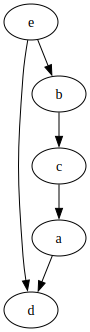

In [4]:
# visualise ground truth DAG
synthetic_data.graph.plot()

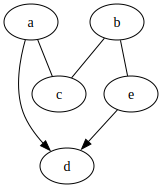

In [5]:
synthetic_data.graph.to_cpdag().plot()

In [6]:
# setup mcmc
n_iterations = 100000
print(synthetic_data.data, synthetic_data.data.values)
M = StructureMCMC(data=synthetic_data.data, score_object='bge', max_iter=n_iterations, pc_init=True, result_type='distribution', seed=100, burn_in=0.1)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'a': 'N', 'b': 'N', 'c': 'N', 'd': 'N', 'e': 'N'}


<structure_learning.data.data.Data object at 0x3448ad640>             a         b         c          d         e
0   -0.196445 -0.039365  0.005593  -0.453780 -0.453966
1    0.928469  0.584385 -0.133857   1.102345 -0.030515
2   -0.195909 -1.806724 -1.310008   0.987758 -0.783253
3    3.672439 -1.553858 -2.504501   5.624512 -1.207085
4    2.118560 -1.030663 -0.707275   2.436619  0.005117
..        ...       ...       ...        ...       ...
195 -3.726553  1.021710  2.485784  -5.164662  1.223314
196  8.735060 -2.204730 -4.911152  11.896884 -1.547577
197 -8.914967  2.234533  5.129776  -7.948369  1.181551
198  2.846533 -1.604027 -1.664003   3.002756 -0.592358
199  2.255836 -0.702683 -1.311533   3.316782 -0.928191

[200 rows x 5 columns]
Running PC algorithm


  0%|          | 0/5 [00:00<?, ?it/s]

In [7]:
# run experiment
mcmc_results, acceptance = M.run()

MCMC iterations: 100001iter [00:12, 7866.20iter/s]                         


In [8]:
mcmc_results.particles[list(mcmc_results.particles.keys())[0]]

{'iteration': [10000,
  10001,
  10002,
  10003,
  10004,
  10005,
  10006,
  10007,
  10038,
  10039,
  10040,
  10041,
  10042,
  10043,
  10044,
  10045,
  10046,
  10358,
  10359,
  10360,
  10361,
  10362,
  10363,
  10364,
  10365,
  10387,
  10435,
  10436,
  10490,
  10491,
  10492,
  10493,
  10513,
  10514,
  10515,
  10516,
  10517,
  10518,
  10519,
  10520,
  10521,
  10522,
  10674,
  10675,
  10676,
  10677,
  11291,
  11292,
  11293,
  11294,
  11295,
  11296,
  11297,
  11298,
  11299,
  11300,
  11301,
  11302,
  11303,
  11304,
  11305,
  11306,
  11307,
  11308,
  11322,
  11323,
  11324,
  11325,
  11326,
  11327,
  11328,
  11329,
  11330,
  11331,
  11332,
  11333,
  11334,
  11421,
  11422,
  11423,
  11424,
  11425,
  11649,
  11650,
  11651,
  11652,
  11701,
  11837,
  11838,
  11920,
  11921,
  11922,
  11923,
  11924,
  11925,
  11926,
  12013,
  12014,
  12015,
  12097,
  12098,
  12099,
  12100,
  12101,
  12102,
  12103,
  12104,
  12116,
  12300,
  1230

In [9]:

print('Acceptance_ratio:', acceptance)

Acceptance_ratio: 0.17954


/Users/165421/Documents/code/structure_learning/examples/../src/structure_learning/distributions/distribution.py:175: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(particles[-limit:], rotation=90)


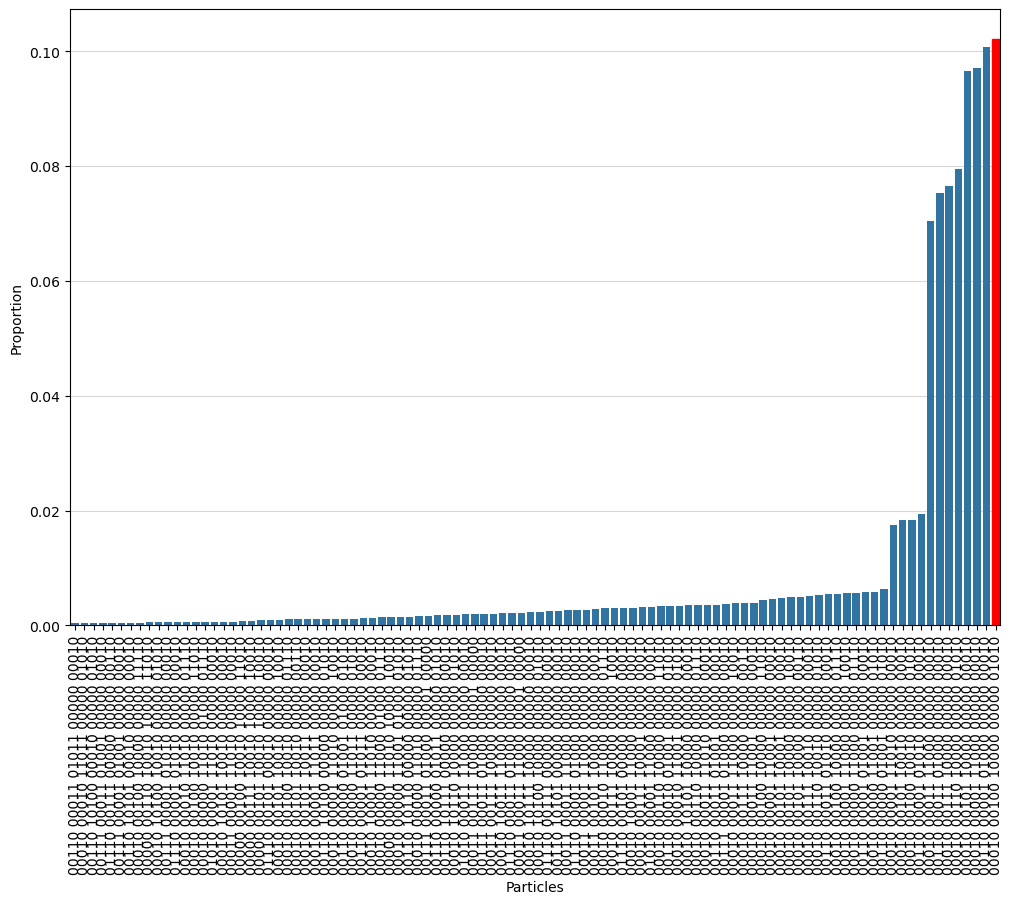

In [10]:
from matplotlib import pyplot as plt

key = synthetic_data.graph.to_key()
plt.rcParams['figure.figsize'] = 12,8
bars, keys, counts = mcmc_results.plot(sort=True, normalise=True, limit=100)
bars.containers[0][np.where(np.array(keys)==key)[0][0]].set_color('red')

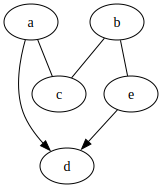

In [11]:
DAG.from_key(key=mcmc_results.top(n=1).item(), nodes=node_labels).to_cpdag().plot()

In [12]:
true_dist = Distribution.compute_distribution(synthetic_data.data, score=BGeScore)

/Users/165421/Documents/code/structure_learning/examples/../src/structure_learning/distributions/distribution.py:175: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(particles[-limit:], rotation=90)


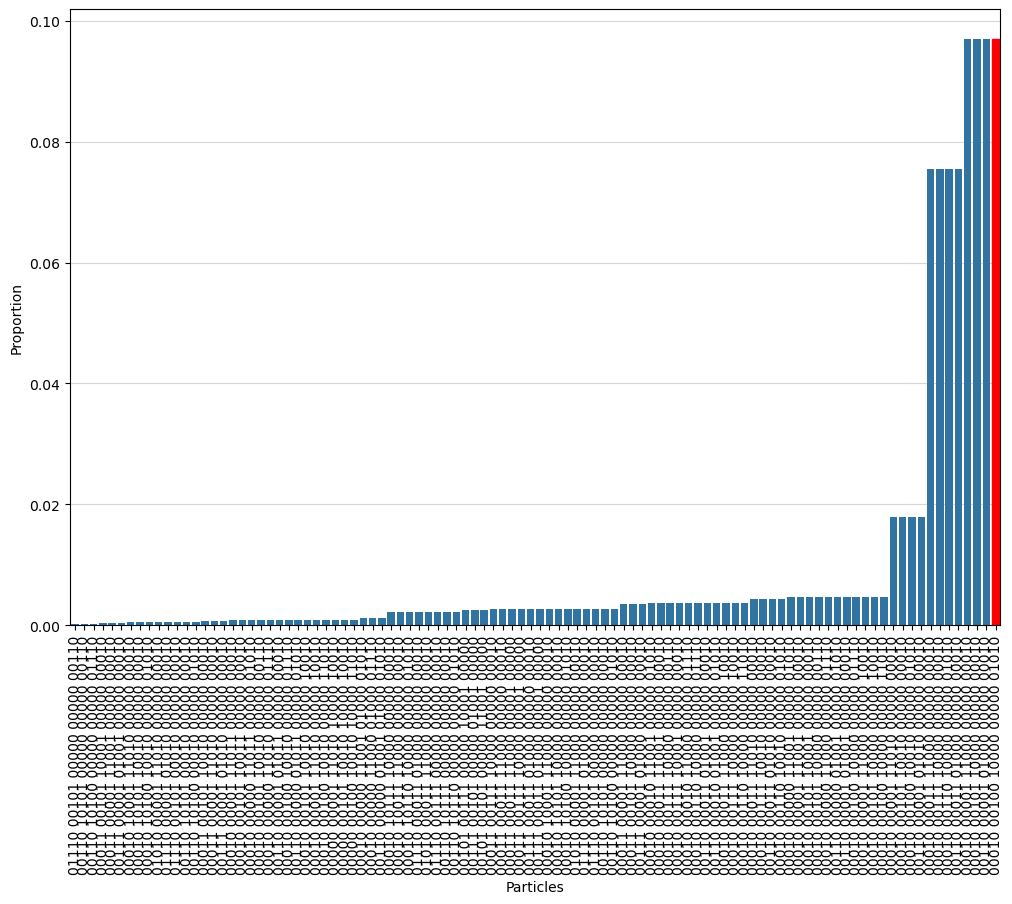

In [13]:

bars2, keys, counts = true_dist.plot(prop='p', sort=True, limit=100)
bars2.containers[0][np.where(np.array(keys)==key)[0][0]].set_color('red')

In [14]:
opad_results = mcmc_results.to_opad()
opad_plus_results = mcmc_results.to_opad(plus=True)

Adding rejected particles


### KLD

In [15]:
kld = KLD()
kld_mcmc = kld.compute(mcmc_results, true_dist)
kld_opad = kld.compute(opad_results, true_dist)
kld_opad_plus = kld.compute(opad_plus_results, true_dist)

print(kld_mcmc, kld_opad, kld_opad_plus)

0.02876767885787481 0.01658197037486802 0.014552303550224332


### JSD

In [16]:
jsd = JSD()
jsd_mcmc = jsd.compute(mcmc_results, true_dist)
jsd_opad = jsd.compute(opad_results, true_dist)
jsd_opad_plus = jsd.compute(opad_plus_results, true_dist)

print(jsd_mcmc, jsd_opad, jsd_opad_plus)

0.008669667540295904 0.005733430620002215 0.005033089880628455


### MSE

In [17]:
mse = MSE()
mse_mcmc = mse.compute(mcmc_results, true_dist)
mse_opad = mse.compute(opad_results, true_dist)
mse_opad_plus = mse.compute(opad_plus_results, true_dist)

print(mse_mcmc, mse_opad, mse_opad_plus)

4.533649288322078e-09 1.2440330182298334e-09 1.1028382582357154e-09


### MAE

In [18]:
mae = MAE()
mae_mcmc = mae.compute(mcmc_results, true_dist)
mae_opad = mae.compute(opad_results, true_dist)
mae_opad_plus = mae.compute(opad_plus_results, true_dist)

print(mae_mcmc, mae_opad, mae_opad_plus)

2.9563268586474366e-06 1.1233172764419516e-06 9.868143112286415e-07


### SHD

In [19]:
shd = SHD()
shd_mcmc = shd.compute(mcmc_results, synthetic_data.graph)
shd_opad = shd.compute(opad_results, synthetic_data.graph)
shd_opad_plus = shd.compute(opad_plus_results, synthetic_data.graph)

print(shd_mcmc, shd_opad, shd_opad_plus)

0.0076453730093689635 0.0076731686373168375 0.001536076808394448


100%|██████████| 296/296 [00:00<00:00, 502433.83it/s]


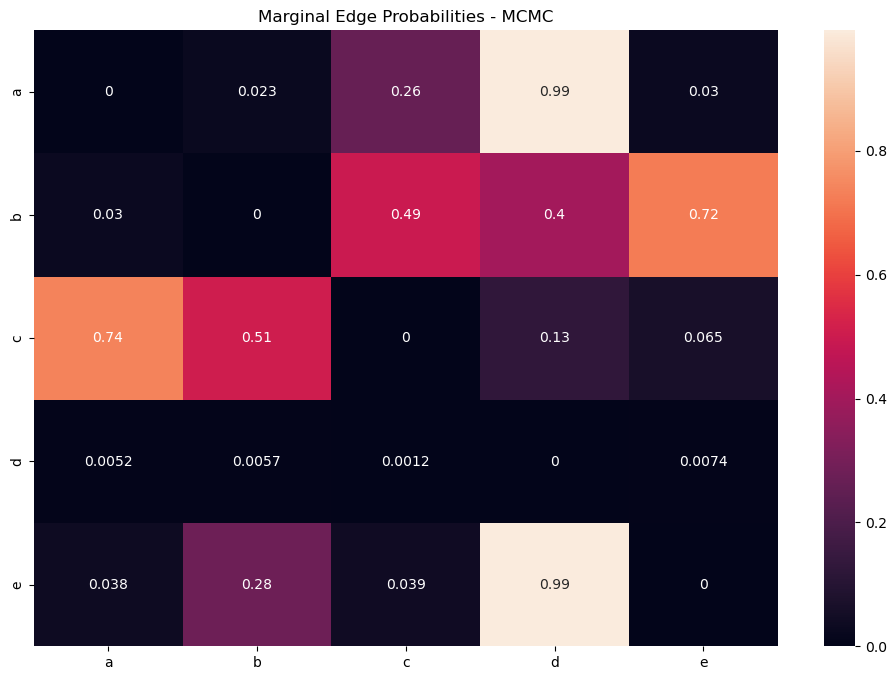

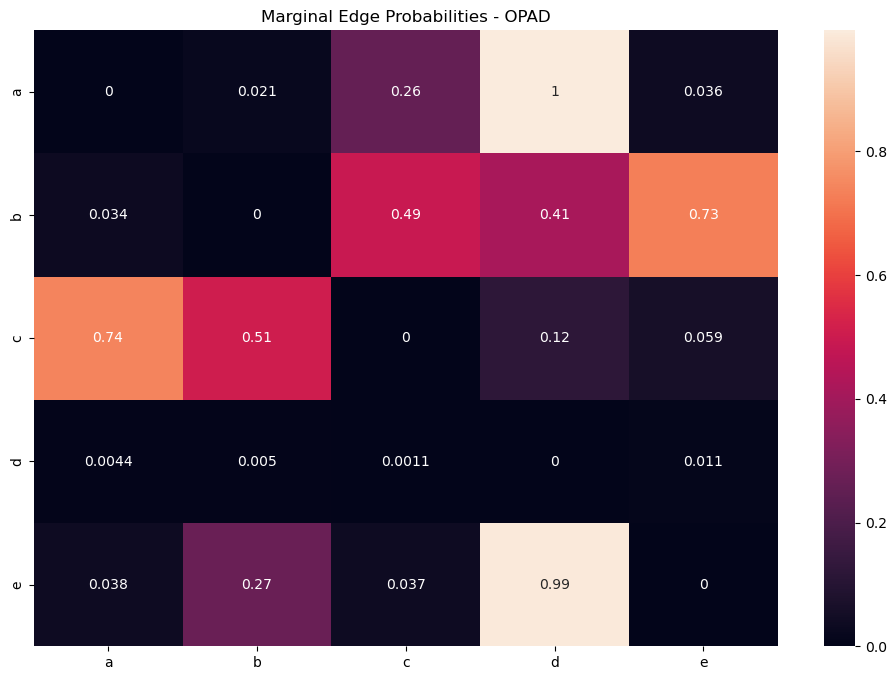

In [20]:
mep = MEP()
mep_mcmc = mep.compute(mcmc_results)
mep_opad = mep.compute(opad_results)

sns.heatmap(mep_mcmc, annot=True, xticklabels=node_labels, yticklabels=node_labels)
plt.title('Marginal Edge Probabilities - MCMC')
plt.show()  

sns.heatmap(mep_opad, annot=True, xticklabels=node_labels, yticklabels=node_labels)
plt.title('Marginal Edge Probabilities - OPAD')
plt.show()

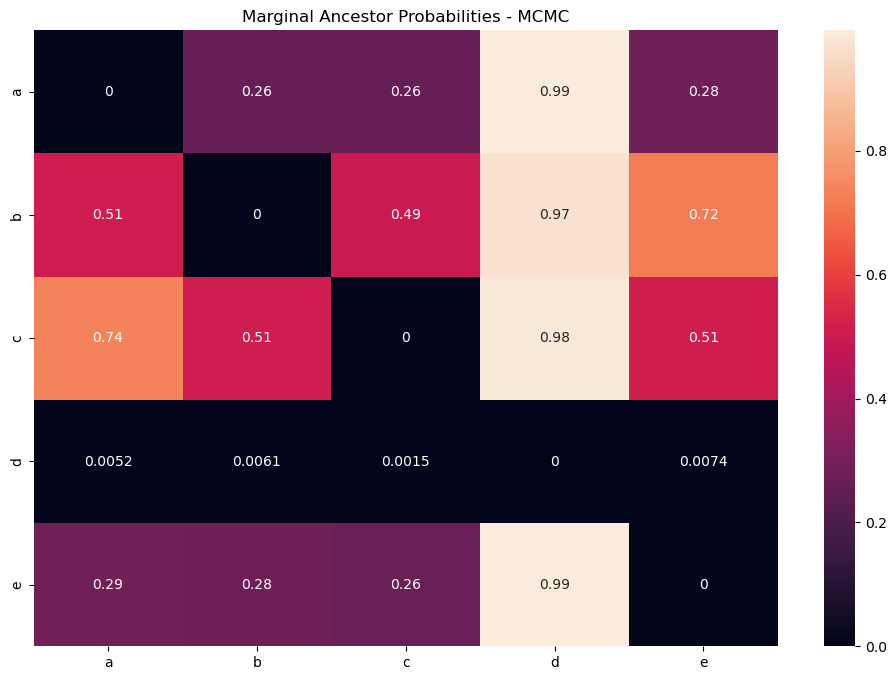

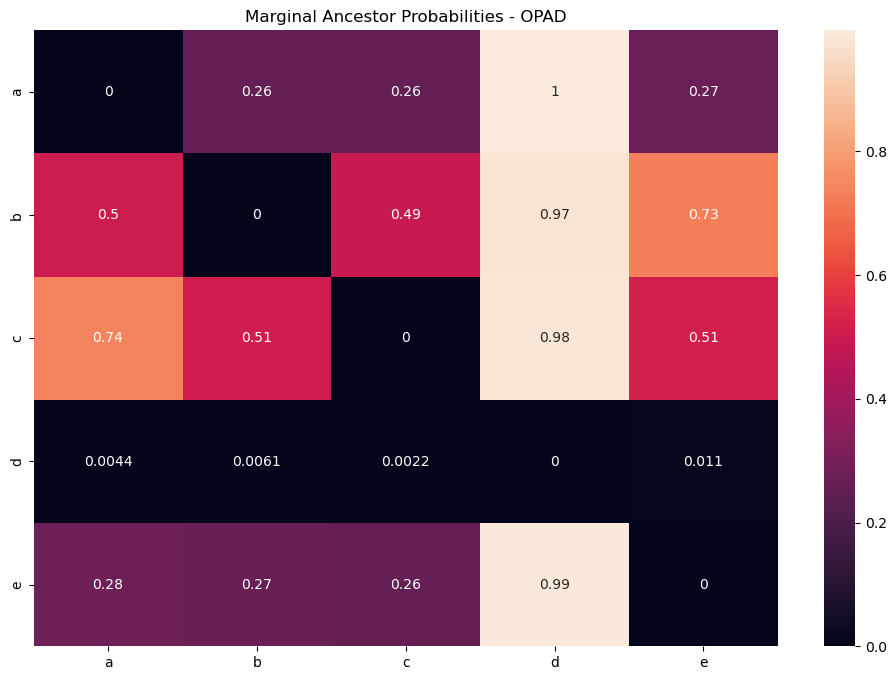

In [22]:
map = MarginalAncestorProbabilities()
map_mcmc = map.compute(mcmc_results)
map_opad = map.compute(opad_results)

sns.heatmap(map_mcmc, annot=True, xticklabels=node_labels, yticklabels=node_labels)
plt.title('Marginal Ancestor Probabilities - MCMC')
plt.show()  

sns.heatmap(map_opad, annot=True, xticklabels=node_labels, yticklabels=node_labels)
plt.title('Marginal Ancestor Probabilities - OPAD')
plt.show()